### Read participant indexes

In [9]:
participants_indexes = []
with open("participants_indexes.txt") as file:
    for line in file:
        participants_indexes.append(int(line.strip()))

In [10]:
import h5py
import pandas as pd
import os

# Directory where the .mat and .csv files are located
directory = "C:\\Users\\Mobile Workstation 3\\OneDrive - Queen's University\\Coding Scripts\\DryRunData\\june_preprocessed_files"

# Initialize an empty dictionary to store the data for each participant
fnirs_dictionary = {}

for participant_index in participants_indexes:
    # Construct the file paths for the .mat file and the .csv files
    mat_file_path = os.path.join(directory, f"fnirs{participant_index}_preprocessed.mat")
    data_csv_path = os.path.join(directory, f"fnirs{participant_index}_data_table.csv")
    events_csv_path = os.path.join(directory, f"fnirs{participant_index}_events_table.csv")
    
    # Check if the files exist before attempting to load them
    if not os.path.exists(mat_file_path) or not os.path.exists(data_csv_path) or not os.path.exists(events_csv_path):
        print(f"Files for participant {participant_index} are missing. Skipping...")
        continue
    
    # Load the .mat file using h5py
    with h5py.File(mat_file_path, 'r') as f:
        # Access the fnirs_mat struct first
        fnirs_mat = f['fnirs_mat']
        
        # Extract variables from the fnirs_mat struct
        sampling_rate = fnirs_mat['sampling_rate'][()][0][0]
        channel_positions_raw = fnirs_mat['channel_positions'][()]
        wavelengths = fnirs_mat['wavelengths'][()].flatten().tolist()
        dpf_value = fnirs_mat['dpf_val'][()][0][0]
    
    # Convert channel_positions to a list of (x, y, z) tuples
    channel_positions = [list(channel_positions_raw[:,i]) for i in range(channel_positions_raw.shape[1])]
    
    # Load the .csv files into pandas DataFrames
    data_table = pd.read_csv(data_csv_path)
    events_table = pd.read_csv(events_csv_path)
    
    # Storing the extracted data in the dictionary
    fnirs_dictionary[participant_index] = {
        'data_table': data_table,
        'sampling_rate': sampling_rate,
        'channel_positions': channel_positions,  # Updated to store as lists of 3
        'wavelengths': wavelengths,
        'dpf_value': dpf_value,
        'events_table': events_table
    }

Files for participant 40 are missing. Skipping...


In [11]:
#fnirs_data_events_dataframe initialization

import pandas as pd

for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        fnirs_data_events_dataframe = fnirs_dictionary[participant_index]['data_table'].copy()
        fnirs_data_events_dataframe['stimulus1'] = None
        events_table = fnirs_dictionary[participant_index]['events_table']
        
        for _, event_row in events_table.iterrows():
            matching_rows = fnirs_data_events_dataframe['times_secs'] == event_row['time_secs']
            if matching_rows.any():
                if fnirs_data_events_dataframe.loc[matching_rows, 'stimulus1'].notnull().any():
                    new_row = fnirs_data_events_dataframe[matching_rows].iloc[0].copy()
                    new_row['stimulus1'] = event_row['stimulus']
                    fnirs_data_events_dataframe = fnirs_data_events_dataframe.append(new_row, ignore_index=True)
                else:
                    fnirs_data_events_dataframe.loc[matching_rows, 'stimulus1'] = event_row['stimulus']
        
        fnirs_data_events_dataframe.sort_values(by='times_secs', inplace=True)
        
        last_valid_stimulus1 = None
        for index, row in fnirs_data_events_dataframe.iterrows():
            if pd.notnull(row['stimulus1']):
                last_valid_stimulus1 = row['stimulus1']
            elif last_valid_stimulus1 is not None:
                fnirs_data_events_dataframe.at[index, 'stimulus1'] = last_valid_stimulus1

        channels = ['S1-D1', 'S2-D1', 'S3-D1', 'S4-D1', 'S5-D2', 'S6-D2', 'S7-D2', 'S8-D2']
        for channel in channels:
            o2hb_col = f'{channel} [O2Hb]'
            hhb_col = f'{channel} [HHb]'
            delta_hb_col = f'{channel} [deltaHb]'
            
            if o2hb_col in fnirs_data_events_dataframe.columns and hhb_col in fnirs_data_events_dataframe.columns:
                fnirs_data_events_dataframe[delta_hb_col] = fnirs_data_events_dataframe[o2hb_col] - fnirs_data_events_dataframe[hhb_col]
            else:
                print(f"Channel {channel} does not exist in the data for participant {participant_index}. Skipping...")

        # Reordering columns
        new_column_order = []
        for channel in channels:
            o2hb_col = f'{channel} [O2Hb]'
            hhb_col = f'{channel} [HHb]'
            delta_hb_col = f'{channel} [deltaHb]'
            if o2hb_col in fnirs_data_events_dataframe.columns:
                new_column_order.append(o2hb_col)
            if hhb_col in fnirs_data_events_dataframe.columns:
                new_column_order.append(hhb_col)
            if delta_hb_col in fnirs_data_events_dataframe.columns:
                new_column_order.append(delta_hb_col)
        remaining_columns = [col for col in fnirs_data_events_dataframe.columns if col not in new_column_order]
        new_column_order.extend(remaining_columns)
        fnirs_data_events_dataframe = fnirs_data_events_dataframe[new_column_order]

        fnirs_dictionary[participant_index]['fnirs_data_events_dataframe'] = fnirs_data_events_dataframe
    else:
        print(f"No data found for participant {participant_index}. Skipping...")

print(fnirs_dictionary[2]['fnirs_data_events_dataframe'])

Channel S7-D2 does not exist in the data for participant 2. Skipping...
Channel S5-D2 does not exist in the data for participant 3. Skipping...
Channel S7-D2 does not exist in the data for participant 3. Skipping...
Channel S7-D2 does not exist in the data for participant 15. Skipping...
Channel S6-D2 does not exist in the data for participant 16. Skipping...
Channel S8-D2 does not exist in the data for participant 16. Skipping...
Channel S7-D2 does not exist in the data for participant 20. Skipping...
Channel S7-D2 does not exist in the data for participant 22. Skipping...
Channel S1-D1 does not exist in the data for participant 25. Skipping...
Channel S7-D2 does not exist in the data for participant 25. Skipping...
Channel S2-D1 does not exist in the data for participant 26. Skipping...
Channel S8-D2 does not exist in the data for participant 26. Skipping...
Channel S7-D2 does not exist in the data for participant 32. Skipping...
Channel S1-D1 does not exist in the data for participa

In [12]:
#fnirs_data_events_dataframe_corrected initialization

for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        fnirs_data_events_dataframe_corrected = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe'].copy()

        rest_mask = fnirs_data_events_dataframe_corrected['stimulus1'].str.contains('LSL ActivePhase Rest', na=False)
        if rest_mask.any():
            rest_indices = fnirs_data_events_dataframe_corrected[rest_mask].index
            start_rest, end_rest = rest_indices[0], rest_indices[-1]

            # Calculate mean values during rest for each channel
            rest_means = {}
            for channel in channels:
                o2hb_col = f'{channel} [O2Hb]'
                hhb_col = f'{channel} [HHb]'
                delta_hb_col = f'{channel} [deltaHb]'
                rest_means[channel] = {}
                if o2hb_col in fnirs_data_events_dataframe_corrected.columns:
                    rest_means[channel]['[O2Hb]'] = fnirs_data_events_dataframe_corrected.loc[start_rest:end_rest, o2hb_col].mean()
                if hhb_col in fnirs_data_events_dataframe_corrected.columns:
                    rest_means[channel]['[HHb]'] = fnirs_data_events_dataframe_corrected.loc[start_rest:end_rest, hhb_col].mean()
                if delta_hb_col in fnirs_data_events_dataframe_corrected.columns:
                    rest_means[channel]['[deltaHb]'] = fnirs_data_events_dataframe_corrected.loc[start_rest:end_rest, delta_hb_col].mean()

            # Apply baseline correction for each channel
            for channel in channels:
                o2hb_col = f'{channel} [O2Hb]'
                hhb_col = f'{channel} [HHb]'
                delta_hb_col = f'{channel} [deltaHb]'
                if o2hb_col in fnirs_data_events_dataframe_corrected.columns:
                    fnirs_data_events_dataframe_corrected[o2hb_col] -= rest_means[channel].get('[O2Hb]', 0)
                if hhb_col in fnirs_data_events_dataframe_corrected.columns:
                    fnirs_data_events_dataframe_corrected[hhb_col] -= rest_means[channel].get('[HHb]', 0)
                if delta_hb_col in fnirs_data_events_dataframe_corrected.columns:
                    fnirs_data_events_dataframe_corrected[delta_hb_col] -= rest_means[channel].get('[deltaHb]', 0)

            # Print rest_means for participant 2
            if participant_index == 2:
                print(f"Rest means for participant {participant_index}: {rest_means}")

        # Update the dictionary with the corrected DataFrame
        fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected'] = fnirs_data_events_dataframe_corrected

# Now you can access the corrected DataFrame like this:
print(fnirs_dictionary[2]['fnirs_data_events_dataframe_corrected'])

Rest means for participant 2: {'S1-D1': {'[O2Hb]': -1.7932009413348468e-05, '[HHb]': 3.7765286836523527e-06, '[deltaHb]': -2.17085380970008e-05}, 'S2-D1': {'[O2Hb]': 0.00010703497527172954, '[HHb]': 3.972838161237496e-06, '[deltaHb]': 0.00010306213711049202}, 'S3-D1': {'[O2Hb]': -2.31539147959728e-05, '[HHb]': -7.622729460594743e-06, '[deltaHb]': -1.5531185335378068e-05}, 'S4-D1': {'[O2Hb]': -0.00012940276021470865, '[HHb]': 1.094831140189357e-05, '[deltaHb]': -0.00014035107161660215}, 'S5-D2': {'[O2Hb]': -6.079760219888387e-05, '[HHb]': 3.765196356075483e-06, '[deltaHb]': -6.456279855495935e-05}, 'S6-D2': {'[O2Hb]': -0.0001334438668358448, '[HHb]': 6.0436941649553336e-06, '[deltaHb]': -0.0001394875610008001}, 'S7-D2': {}, 'S8-D2': {'[O2Hb]': -2.9441867752833742e-05, '[HHb]': 5.8464292629777324e-05, '[deltaHb]': -8.790616038261101e-05}}
       S1-D1 [O2Hb]  S1-D1 [HHb]  S1-D1 [deltaHb]  S2-D1 [O2Hb]  S2-D1 [HHb]  \
0          0.000729    -0.000864         0.001593      0.010289    -0.0

In [13]:
#fnirs_data_events_dataframe_corrected_single_channel intialization

for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected']
        
        # Extract the O2Hb, HHb, and deltaHb columns
        o2hb_columns = [col for col in events_df.columns if '[O2Hb]' in col]
        hhb_columns = [col for col in events_df.columns if '[HHb]' in col]
        deltahb_columns = [col for col in events_df.columns if '[deltaHb]' in col]

        # Calculate the row-wise average for each set of columns
        average_o2hb = events_df[o2hb_columns].mean(axis=1)
        average_hhb = events_df[hhb_columns].mean(axis=1)
        average_deltahb = events_df[deltahb_columns].mean(axis=1)

        # Create the new DataFrame
        fnirs_data_events_dataframe_corrected_single_channel = pd.DataFrame({
            'times_secs': events_df['times_secs'],
            '[O2Hb]': average_o2hb,
            '[HHb]': average_hhb,
            '[deltaHb]': average_deltahb,
            'stimulus1': events_df['stimulus1']
        })

        fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected_single_channel'] = fnirs_data_events_dataframe_corrected_single_channel

# Print the DataFrame for participant 2
print(fnirs_dictionary[2]['fnirs_data_events_dataframe_corrected_single_channel'])

       times_secs    [O2Hb]     [HHb]  [deltaHb]                stimulus1
0            0.00  0.004860 -0.002330   0.007189                     None
1            0.04  0.110098  0.011795   0.098303                     None
2            0.08  0.213771  0.025705   0.188067                     None
3            0.12  0.314274  0.039184   0.275089                     None
4            0.16  0.410090  0.052034   0.358056                     None
...           ...       ...       ...        ...                      ...
57856     2314.24  0.001185  0.000260   0.000925  LSL Quitting experiment
57857     2314.28  0.001196  0.000243   0.000953  LSL Quitting experiment
57858     2314.32  0.001209  0.000228   0.000981  LSL Quitting experiment
57859     2314.36  0.001224  0.000215   0.001009  LSL Quitting experiment
57860     2314.40  0.001239  0.000204   0.001035  LSL Quitting experiment

[57865 rows x 5 columns]


In [14]:
#stimulus_duration_initialization

for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary:
        events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected']
        
        # Initialize variables
        stimulus_events = []
        previous_stimulus = None
        start_time_secs = None
        
        for index, row in events_df.iterrows():
            current_stimulus = row['stimulus1']
            current_time_secs = row['times_secs']
            
            # Check if the stimulus has changed
            if current_stimulus != previous_stimulus:
                # If this is not the first stimulus, save the previous stimulus event
                if previous_stimulus is not None:
                    end_time_secs = previous_time_secs
                    stimulus_events.append({
                        'stimulus': previous_stimulus,
                        'start_time': start_time_secs,
                        'end_time': end_time_secs,
                        'duration': end_time_secs - start_time_secs
                    })
                
                # Reset start time for the new stimulus
                start_time_secs = current_time_secs
            
            # Update previous stimulus and time for the next iteration
            previous_stimulus = current_stimulus
            previous_time_secs = current_time_secs
        
        # Add the last stimulus event
        if previous_stimulus is not None:
            stimulus_events.append({
                'stimulus': previous_stimulus,
                'start_time': start_time_secs,
                'end_time': previous_time_secs,
                'duration': previous_time_secs - start_time_secs
            })
        
        # Group durations by stimulus
        grouped_durations = {}
        for event in stimulus_events:
            stimulus_name = event['stimulus']
            duration = event['duration']
            if stimulus_name not in grouped_durations:
                grouped_durations[stimulus_name] = [duration]
            else:
                grouped_durations[stimulus_name].append(duration)
        
        # Store the grouped durations inside the participant's entry in fnirs_dictionary
        fnirs_dictionary[participant_index]['stimulus_duration'] = grouped_durations

In [43]:
#fnirs_trial_data initialization

for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_data_events_dataframe_corrected_single_channel' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_data'] = {}
    participant_fnirs_events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected_single_channel']
    participant_fnirs_events_df['stimulus1'] = participant_fnirs_events_df['stimulus1'].fillna('NoStimulus')
    
    for trial_number in range(32):  
        trial_stimulus_pattern = f'LSL RunningTrial {trial_number}_'
        trial_rows_filter = participant_fnirs_events_df['stimulus1'].str.startswith(trial_stimulus_pattern)
        trial_specific_df = participant_fnirs_events_df[trial_rows_filter]
        
        # Store the trial data using trial_number directly
        fnirs_dictionary[participant_index]['fnirs_trial_data'][trial_number] = trial_specific_df
        
print(fnirs_dictionary[2]['fnirs_trial_data'][0])

       times_secs    [O2Hb]     [HHb]  [deltaHb]  \
20201      808.04 -0.002781  0.003870  -0.006651   
20202      808.08 -0.003002  0.003871  -0.006873   
20203      808.12 -0.003309  0.003854  -0.007163   
20204      808.16 -0.003708  0.003818  -0.007525   
20205      808.20 -0.004204  0.003760  -0.007963   
...           ...       ...       ...        ...   
21271      850.84  0.004502  0.002477   0.002025   
21272      850.88  0.004619  0.002412   0.002206   
21273      850.92  0.004704  0.002345   0.002360   
21274      850.96  0.004759  0.002275   0.002484   
21275      851.00  0.004783  0.002205   0.002578   

                                stimulus1  
20201  LSL RunningTrial 0_A1_CI_NSI_R180x  
20202  LSL RunningTrial 0_A1_CI_NSI_R180x  
20203  LSL RunningTrial 0_A1_CI_NSI_R180x  
20204  LSL RunningTrial 0_A1_CI_NSI_R180x  
20205  LSL RunningTrial 0_A1_CI_NSI_R180x  
...                                   ...  
21271  LSL RunningTrial 0_A1_CI_NSI_R180x  
21272  LSL RunningTrial

In [44]:
# fnirs_trial_avg_peaks initialization with average value capture from times_secs column
for participant_index in fnirs_dictionary:
    if 'fnirs_trial_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_avg_peaks'] = {}
    
    for trial_number, trial_data in fnirs_dictionary[participant_index]['fnirs_trial_data'].items():
        fnirs_avg_o2hb_peak = None
        fnirs_avg_hhb_peak = None
        fnirs_avg_deltahb_peak = None
        
        # Find average peaks
        if '[O2Hb]' in trial_data.columns:
            fnirs_avg_o2hb_peak = trial_data['[O2Hb]'].mean()
        
        if '[HHb]' in trial_data.columns:
            fnirs_avg_hhb_peak = trial_data['[HHb]'].mean()
        
        if '[deltaHb]' in trial_data.columns:
            fnirs_avg_deltahb_peak = trial_data['[deltaHb]'].mean()
        
        fnirs_dictionary[participant_index]['fnirs_trial_avg_peaks'][trial_number] = {
            'O2Hb': {
                'avg_peak': fnirs_avg_o2hb_peak
            },
            'HHb': {
                'avg_peak': fnirs_avg_hhb_peak
            },
            'deltaHb': {
                'avg_peak': fnirs_avg_deltahb_peak
            }
        }

print(fnirs_dictionary[2]['fnirs_trial_avg_peaks'][1])

{'O2Hb': {'avg_peak': -0.0013717822620712093}, 'HHb': {'avg_peak': -0.0014193905514978595}, 'deltaHb': {'avg_peak': 4.760828942665006e-05}}


In [45]:
# fnirs_trial_highest_peaks initialization with timepoint capture from times_secs column
for participant_index in fnirs_dictionary:
    if 'fnirs_trial_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_highest_peaks'] = {}
    
    for trial_number, trial_data in fnirs_dictionary[participant_index]['fnirs_trial_data'].items():
        fnirs_max_o2hb_peak = float('-inf')
        fnirs_max_hhb_peak = float('-inf')
        fnirs_max_deltahb_peak = float('-inf')
        fnirs_max_o2hb_timepoint = None
        fnirs_max_hhb_timepoint = None
        fnirs_max_deltahb_timepoint = None
        
        trial_start_time = trial_data['times_secs'].min()
        
        # Find max peaks and corresponding timepoints
        if '[O2Hb]' in trial_data.columns:
            fnirs_max_o2hb_peak = trial_data['[O2Hb]'].max()
            max_index = trial_data['[O2Hb]'].idxmax()
            fnirs_max_o2hb_timepoint = trial_data.loc[max_index, 'times_secs']
            fnirs_max_o2hb_timepoint_from_start = round(fnirs_max_o2hb_timepoint - trial_start_time, 2)
        
        if '[HHb]' in trial_data.columns:
            fnirs_max_hhb_peak = trial_data['[HHb]'].max()
            max_index = trial_data['[HHb]'].idxmax()
            fnirs_max_hhb_timepoint = trial_data.loc[max_index, 'times_secs']
            fnirs_max_hhb_timepoint_from_start = round(fnirs_max_hhb_timepoint - trial_start_time, 2)
        
        if '[deltaHb]' in trial_data.columns:
            fnirs_max_deltahb_peak = trial_data['[deltaHb]'].max()
            max_index = trial_data['[deltaHb]'].idxmax()
            fnirs_max_deltahb_timepoint = trial_data.loc[max_index, 'times_secs']
            fnirs_max_deltahb_timepoint_from_start = round(fnirs_max_deltahb_timepoint - trial_start_time, 2)
        
        fnirs_dictionary[participant_index]['fnirs_trial_highest_peaks'][trial_number] = {
            'O2Hb': {
                'highest_peak': fnirs_max_o2hb_peak, 
                'timepoint': fnirs_max_o2hb_timepoint, 
                'timepoint_from_start': fnirs_max_o2hb_timepoint_from_start
            },
            'HHb': {
                'highest_peak': fnirs_max_hhb_peak, 
                'timepoint': fnirs_max_hhb_timepoint, 
                'timepoint_from_start': fnirs_max_hhb_timepoint_from_start
            },
            'deltaHb': {
                'highest_peak': fnirs_max_deltahb_peak, 
                'timepoint': fnirs_max_deltahb_timepoint, 
                'timepoint_from_start': fnirs_max_deltahb_timepoint_from_start
            }
        }

print(fnirs_dictionary[2]['fnirs_trial_highest_peaks'])

{0: {'O2Hb': {'highest_peak': 0.016712155549419978, 'timepoint': 846.8, 'timepoint_from_start': 38.76}, 'HHb': {'highest_peak': 0.005811427349294715, 'timepoint': 846.88, 'timepoint_from_start': 38.84}, 'deltaHb': {'highest_peak': 0.011038926111125266, 'timepoint': 846.76, 'timepoint_from_start': 38.72}}, 1: {'O2Hb': {'highest_peak': 0.00999722884941998, 'timepoint': 855.0, 'timepoint_from_start': 1.92}, 'HHb': {'highest_peak': 0.0021031421811518575, 'timepoint': 862.12, 'timepoint_from_start': 9.04}, 'deltaHb': {'highest_peak': 0.014095855239696696, 'timepoint': 855.0, 'timepoint_from_start': 1.92}}, 2: {'O2Hb': {'highest_peak': 0.011089454149419978, 'timepoint': 870.0, 'timepoint_from_start': 5.76}, 'HHb': {'highest_peak': 0.0028077641097232864, 'timepoint': 864.24, 'timepoint_from_start': 0.0}, 'deltaHb': {'highest_peak': 0.012789951125410981, 'timepoint': 869.96, 'timepoint_from_start': 5.72}}, 3: {'O2Hb': {'highest_peak': 0.006186862506562837, 'timepoint': 899.68, 'timepoint_from_

-0.012323261638612101


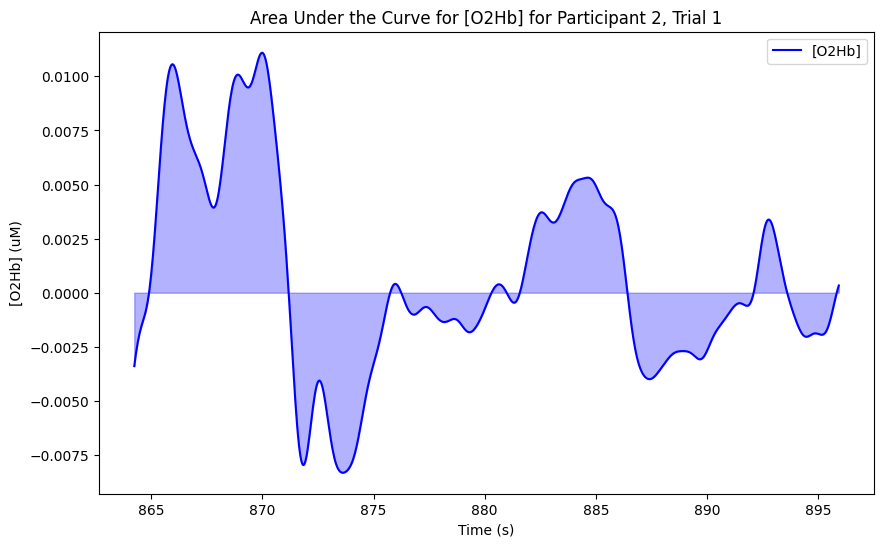

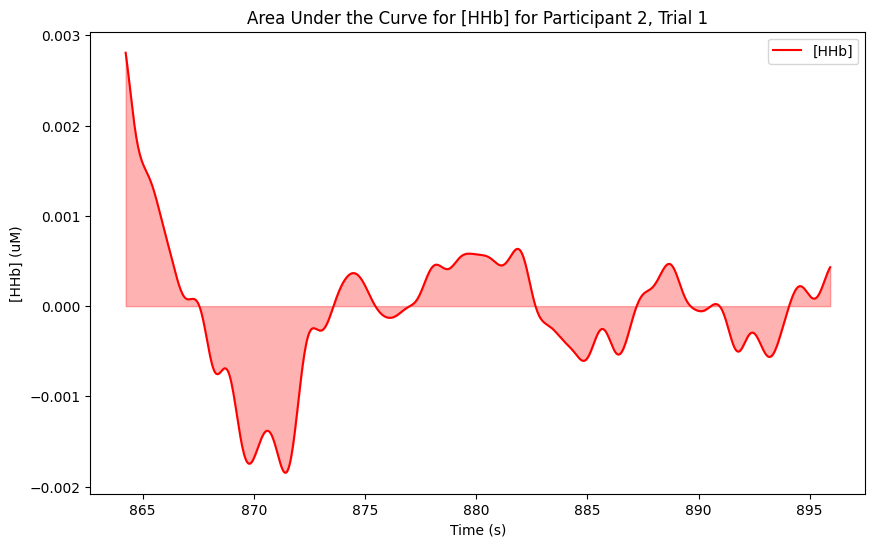

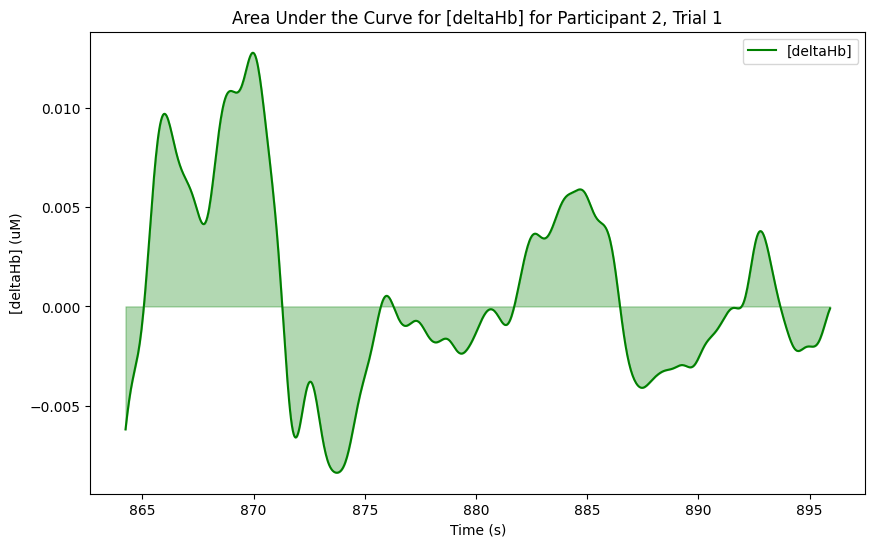

In [46]:
from scipy.integrate import trapz
import matplotlib.pyplot as plt

# Calculate AUC for each trial and store in fnirs_trial_auc
for participant_index in fnirs_dictionary:
    if 'fnirs_trial_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_auc'] = {}
    
    for trial_number, trial_data in fnirs_dictionary[participant_index]['fnirs_trial_data'].items():
        trial_start_time = trial_data['times_secs'].min()
        
        # Initialize AUC values
        fnirs_auc_o2hb = None
        fnirs_auc_hhb = None
        fnirs_auc_deltahb = None
        
        # Calculate AUC for [O2Hb]
        if '[O2Hb]' in trial_data.columns:
            fnirs_auc_o2hb = trapz(trial_data['[O2Hb]'], trial_data['times_secs'])
        
        # Calculate AUC for [HHb]
        if '[HHb]' in trial_data.columns:
            fnirs_auc_hhb = trapz(trial_data['[HHb]'], trial_data['times_secs'])
        
        # Calculate AUC for [deltaHb]
        if '[deltaHb]' in trial_data.columns:
            fnirs_auc_deltahb = trapz(trial_data['[deltaHb]'], trial_data['times_secs'])
        
        # Store the AUC values in the dictionary
        fnirs_dictionary[participant_index]['fnirs_trial_auc'][trial_number] = {
            'O2Hb': fnirs_auc_o2hb,
            'HHb': fnirs_auc_hhb,
            'deltaHb': fnirs_auc_deltahb
        }

print(fnirs_dictionary[2]['fnirs_trial_auc'][1]['O2Hb'])

# Extract data for participant 2, trial 1 in a single line
trial_data = fnirs_dictionary[2]['fnirs_trial_data'][2]
time = trial_data['times_secs']

# Plot and shade the area under the curve for [O2Hb]
if '[O2Hb]' in trial_data.columns:
    o2hb_signal = trial_data['[O2Hb]']
    plt.figure(figsize=(10, 6))
    plt.plot(time, o2hb_signal, label='[O2Hb]', color='blue')
    plt.fill_between(time, o2hb_signal, color='blue', alpha=0.3)
    plt.title('Area Under the Curve for [O2Hb] for Participant 2, Trial 1')
    plt.xlabel('Time (s)')
    plt.ylabel('[O2Hb] (uM)')
    plt.legend()
    plt.show()

# Plot and shade the area under the curve for [HHb]
if '[HHb]' in trial_data.columns:
    hhb_signal = trial_data['[HHb]']
    plt.figure(figsize=(10, 6))
    plt.plot(time, hhb_signal, label='[HHb]', color='red')
    plt.fill_between(time, hhb_signal, color='red', alpha=0.3)
    plt.title('Area Under the Curve for [HHb] for Participant 2, Trial 1')
    plt.xlabel('Time (s)')
    plt.ylabel('[HHb] (uM)')
    plt.legend()
    plt.show()

# Plot and shade the area under the curve for [deltaHb]
if '[deltaHb]' in trial_data.columns:
    deltahb_signal = trial_data['[deltaHb]']
    plt.figure(figsize=(10, 6))
    plt.plot(time, deltahb_signal, label='[deltaHb]', color='green')
    plt.fill_between(time, deltahb_signal, color='green', alpha=0.3)
    plt.title('Area Under the Curve for [deltaHb] for Participant 2, Trial 1')
    plt.xlabel('Time (s)')
    plt.ylabel('[deltaHb] (uM)')
    plt.legend()
    plt.show()

In [47]:
# fnirs_trial_lowest_peaks initialization with timepoint capture from times_secs column
for participant_index in fnirs_dictionary:
    if 'fnirs_trial_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_lowest_peaks'] = {}
    
    for trial_number, trial_data in fnirs_dictionary[participant_index]['fnirs_trial_data'].items():
        fnirs_min_o2hb_peak = float('inf')
        fnirs_min_hhb_peak = float('inf')
        fnirs_min_deltahb_peak = float('inf')
        fnirs_min_o2hb_timepoint = None
        fnirs_min_hhb_timepoint = None
        fnirs_min_deltahb_timepoint = None
        
        trial_start_time = trial_data['times_secs'].min()
        
        # Find min peaks and corresponding timepoints
        if '[O2Hb]' in trial_data.columns:
            fnirs_min_o2hb_peak = trial_data['[O2Hb]'].min()
            min_index = trial_data['[O2Hb]'].idxmin()
            fnirs_min_o2hb_timepoint = trial_data.loc[min_index, 'times_secs']
            fnirs_min_o2hb_timepoint_from_start = round(fnirs_min_o2hb_timepoint - trial_start_time, 2)
        
        if '[HHb]' in trial_data.columns:
            fnirs_min_hhb_peak = trial_data['[HHb]'].min()
            min_index = trial_data['[HHb]'].idxmin()
            fnirs_min_hhb_timepoint = trial_data.loc[min_index, 'times_secs']
            fnirs_min_hhb_timepoint_from_start = round(fnirs_min_hhb_timepoint - trial_start_time, 2)
        
        if '[deltaHb]' in trial_data.columns:
            fnirs_min_deltahb_peak = trial_data['[deltaHb]'].min()
            min_index = trial_data['[deltaHb]'].idxmin()
            fnirs_min_deltahb_timepoint = trial_data.loc[min_index, 'times_secs']
            fnirs_min_deltahb_timepoint_from_start = round(fnirs_min_deltahb_timepoint - trial_start_time, 2)
        
        fnirs_dictionary[participant_index]['fnirs_trial_lowest_peaks'][trial_number] = {
            'O2Hb': {
                'lowest_peak': fnirs_min_o2hb_peak, 
                'timepoint': fnirs_min_o2hb_timepoint, 
                'timepoint_from_start': fnirs_min_o2hb_timepoint_from_start
            },
            'HHb': {
                'lowest_peak': fnirs_min_hhb_peak, 
                'timepoint': fnirs_min_hhb_timepoint, 
                'timepoint_from_start': fnirs_min_hhb_timepoint_from_start
            },
            'deltaHb': {
                'lowest_peak': fnirs_min_deltahb_peak, 
                'timepoint': fnirs_min_deltahb_timepoint, 
                'timepoint_from_start': fnirs_min_deltahb_timepoint_from_start
            }
        }

print(fnirs_dictionary[2]['fnirs_trial_lowest_peaks'])

{0: {'O2Hb': {'lowest_peak': -0.023325425279151452, 'timepoint': 809.08, 'timepoint_from_start': 1.04}, 'HHb': {'lowest_peak': -0.0032172936745624276, 'timepoint': 845.76, 'timepoint_from_start': 37.72}, 'deltaHb': {'lowest_peak': -0.022127639603160446, 'timepoint': 809.04, 'timepoint_from_start': 1.0}}, 1: {'O2Hb': {'lowest_peak': -0.014101490122008592, 'timepoint': 853.96, 'timepoint_from_start': 0.88}, 'HHb': {'lowest_peak': -0.004322281275990999, 'timepoint': 854.48, 'timepoint_from_start': 1.4}, 'deltaHb': {'lowest_peak': -0.011756663031731876, 'timepoint': 861.64, 'timepoint_from_start': 8.56}}, 2: {'O2Hb': {'lowest_peak': -0.008317473136294306, 'timepoint': 873.6, 'timepoint_from_start': 9.36}, 'HHb': {'lowest_peak': -0.0018457932617052854, 'timepoint': 871.44, 'timepoint_from_start': 7.2}, 'deltaHb': {'lowest_peak': -0.00838335377458902, 'timepoint': 873.76, 'timepoint_from_start': 9.52}}, 3: {'O2Hb': {'lowest_peak': -0.004494547507722877, 'timepoint': 903.32, 'timepoint_from_s

In [48]:
# Initialize the difference peaks dictionary for trials
for participant_index in fnirs_dictionary:
    if 'fnirs_trial_highest_peaks' not in fnirs_dictionary[participant_index] or 'fnirs_trial_lowest_peaks' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_difference_peaks'] = {}
    
    for trial_number in fnirs_dictionary[participant_index]['fnirs_trial_highest_peaks']:
        if trial_number not in fnirs_dictionary[participant_index]['fnirs_trial_lowest_peaks']:
            continue
        
        highest_peaks = fnirs_dictionary[participant_index]['fnirs_trial_highest_peaks'][trial_number]
        lowest_peaks = fnirs_dictionary[participant_index]['fnirs_trial_lowest_peaks'][trial_number]
        
        difference_peaks = {
            'O2Hb': abs(highest_peaks['O2Hb']['highest_peak'] - lowest_peaks['O2Hb']['lowest_peak']),
            'HHb': abs(highest_peaks['HHb']['highest_peak'] - lowest_peaks['HHb']['lowest_peak']),
            'deltaHb': abs(highest_peaks['deltaHb']['highest_peak'] - lowest_peaks['deltaHb']['lowest_peak'])
        }
        
        fnirs_dictionary[participant_index]['fnirs_trial_difference_peaks'][trial_number] = difference_peaks

print(fnirs_dictionary[2]['fnirs_trial_difference_peaks'][1])

{'O2Hb': 0.02409871897142857, 'HHb': 0.006425423457142856, 'deltaHb': 0.025852518271428572}


In [31]:
#fnirs_trial_trends intialization

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Initialize fnirs_trial_trends for each participant
for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_data_events_dataframe_corrected_single_channel' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_trial_trends'] = {}
    participant_fnirs_events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected_single_channel']
    participant_fnirs_events_df['stimulus1'] = participant_fnirs_events_df['stimulus1'].fillna('NoStimulus')
    
    # Strip whitespace from column names
    participant_fnirs_events_df.columns = participant_fnirs_events_df.columns.str.strip()
    
    for trial_number in range(32):  
        trial_stimulus_pattern = f'LSL RunningTrial {trial_number}_'
        trial_rows_filter = participant_fnirs_events_df['stimulus1'].str.startswith(trial_stimulus_pattern)
        trial_specific_df = participant_fnirs_events_df[trial_rows_filter]
        
        # Initialize trial trends for the current trial
        fnirs_dictionary[participant_index]['fnirs_trial_trends'][trial_number] = {}
        
        # Extract time values
        time_values = trial_specific_df['times_secs'].values.reshape(-1, 1)
        
        # Function to process each channel type
        def process_channel(channel_name, channel_type):
            values = trial_specific_df[channel_name].values
            
            # Remove rows with NaN values
            valid_indices = ~np.isnan(values)
            valid_time_values = time_values[valid_indices]
            valid_values = values[valid_indices]
            
            if len(valid_values) == 0:
                return  # Skip if no valid data points
            
            # Perform linear regression
            model = LinearRegression()
            model.fit(valid_time_values, valid_values)
            slope = model.coef_[0]
            intercept = model.intercept_
            
            # Store the trendline results
            fnirs_dictionary[participant_index]['fnirs_trial_trends'][trial_number][channel_type] = {
                'slope': slope,
                'intercept': intercept
            }
        
        # Process each type of channel
        process_channel('[O2Hb]', 'O2Hb')
        process_channel('[HHb]', 'HHb')
        process_channel('[deltaHb]', 'deltaHb')

# Example query to print the trendline for participant 2, trial 0
print(fnirs_dictionary[81]['fnirs_trial_trends'][0])

{'O2Hb': {'slope': -0.0019445015702282836, 'intercept': 1.4191451730186238}, 'HHb': {'slope': -0.0003484663031738027, 'intercept': 0.2544097283973745}, 'deltaHb': {'slope': -0.001596035267054481, 'intercept': 1.164735444621249}}


In [32]:
# fnirs_subexperiment_data intialization

import pandas as pd

def filter_subexperiment_data(events_df, start_trial, end_trial):
    # Create a list of stimuli to include in the subexperiment
    stimuli_to_include = []
    for trial in range(start_trial, end_trial + 1):
        stimuli_to_include.append(f'LSL RunningTrial {trial}_')
        stimuli_to_include.append(f'LSL RunningTrial {trial} isCorrect?')
    
    # Filter the DataFrame to include only the rows with the specified stimuli
    subexperiment_df = events_df[events_df['stimulus1'].apply(lambda x: any(x.startswith(stimulus) for stimulus in stimuli_to_include))]
    
    return subexperiment_df

# Initialize fnirs_subexperiment_data
for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_data_events_dataframe_corrected_single_channel' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_data'] = {}
    
    # Get the corrected single channel dataframe
    events_df = fnirs_dictionary[participant_index]['fnirs_data_events_dataframe_corrected_single_channel']
    
    for subexperiment_number in range(1, 9): 
        start_trial = (subexperiment_number - 1) * 4
        end_trial = start_trial + 3
        
        # Filter the dataframe to include rows between the start and end stimuli
        subexperiment_df = filter_subexperiment_data(events_df, start_trial, end_trial)
        
        # Store the DataFrame in the dictionary
        fnirs_dictionary[participant_index]['fnirs_subexperiment_data'][subexperiment_number] = subexperiment_df

# Print the data for the first subexperiment of participant 2
print(fnirs_dictionary[2]['fnirs_subexperiment_data'][3])

       times_secs    [O2Hb]     [HHb]  [deltaHb]  \
25953     1038.12 -0.003732  0.000117  -0.003848   
25954     1038.16 -0.003943  0.000120  -0.004063   
25955     1038.20 -0.004120  0.000124  -0.004243   
25956     1038.24 -0.004261  0.000128  -0.004390   
25957     1038.28 -0.004369  0.000133  -0.004502   
...           ...       ...       ...        ...   
29453     1178.12  0.000840  0.001140  -0.000300   
29454     1178.16  0.001071  0.001190  -0.000120   
29455     1178.20  0.001278  0.001241   0.000037   
29456     1178.24  0.001462  0.001291   0.000170   
29457     1178.28  0.001619  0.001341   0.000278   

                                 stimulus1  
25953    LSL RunningTrial 8_A5_AC_SI_R180y  
25954    LSL RunningTrial 8_A5_AC_SI_R180y  
25955    LSL RunningTrial 8_A5_AC_SI_R180y  
25956    LSL RunningTrial 8_A5_AC_SI_R180y  
25957    LSL RunningTrial 8_A5_AC_SI_R180y  
...                                    ...  
29453  LSL RunningTrial 11 isCorrect? Fals  
29454  LSL Runn

In [33]:
# fnirs_subexperiment_highest_peaks initialization
for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_subexperiment_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_highest_peaks'] = {}
    
    for subexperiment_number, subexperiment_data in fnirs_dictionary[participant_index]['fnirs_subexperiment_data'].items():
        o2hb_column = '[O2Hb]'
        hhb_columns = [col for col in subexperiment_data.columns if '[HHb]' in col]
        deltahb_columns = [col for col in subexperiment_data.columns if '[deltaHb]' in col]
        
        trial_numbers = subexperiment_data['stimulus1'].unique()
        
        for trial_number in trial_numbers:
            trial_data = subexperiment_data[subexperiment_data['stimulus1'] == trial_number]
        
            fnirs_max_o2hb_peak = -float('inf')  
            fnirs_max_hhb_peak = -float('inf')  
            fnirs_max_deltahb_peak = -float('inf')  
            
            fnirs_max_o2hb_timepoint = None
            fnirs_max_hhb_timepoint = None
            fnirs_max_deltahb_timepoint = None
            
            subexperiment_start_time = subexperiment_data['times_secs'].min()
            
            # Initialize trial_number variables for each peak type
            trial_number_o2hb = trial_number_hhb = trial_number_deltahb = None
            
            if o2hb_column in subexperiment_data.columns:
                current_max = subexperiment_data[o2hb_column].max()
                if current_max > fnirs_max_o2hb_peak:
                    fnirs_max_o2hb_peak = current_max
                    max_index = subexperiment_data[o2hb_column].idxmax()
                    fnirs_max_o2hb_timepoint = subexperiment_data.loc[max_index, 'times_secs']
                    fnirs_max_o2hb_timepoint_from_start = round(fnirs_max_o2hb_timepoint - subexperiment_start_time, 2)
                    trial_number_o2hb = subexperiment_data.loc[max_index, 'stimulus1']  
                        
            if hhb_columns:
                for col in hhb_columns:
                    current_max = subexperiment_data[col].max()
                    if current_max > fnirs_max_hhb_peak:
                        fnirs_max_hhb_peak = current_max
                        max_index = subexperiment_data[col].idxmax()
                        fnirs_max_hhb_timepoint = subexperiment_data.loc[max_index, 'times_secs']
                        fnirs_max_hhb_timepoint_from_start = round(fnirs_max_hhb_timepoint - subexperiment_start_time, 2)
                        trial_number_hhb = subexperiment_data.loc[max_index, 'stimulus1'] 
                        
            if deltahb_columns:
                for col in deltahb_columns:
                    current_max = subexperiment_data[col].max()
                    if current_max > fnirs_max_deltahb_peak:
                        fnirs_max_deltahb_peak = current_max
                        max_index = subexperiment_data[col].idxmax()
                        fnirs_max_deltahb_timepoint = subexperiment_data.loc[max_index, 'times_secs']
                        fnirs_max_deltahb_timepoint_from_start = round(fnirs_max_deltahb_timepoint - subexperiment_start_time, 2)
                        trial_number_deltahb = subexperiment_data.loc[max_index, 'stimulus1'] 
            
            # Update the dictionary with specific trial_number variables
            fnirs_dictionary[participant_index]['fnirs_subexperiment_highest_peaks'][subexperiment_number] = {
                'O2Hb': {'highest_peak': fnirs_max_o2hb_peak, 'timepoint': fnirs_max_o2hb_timepoint, 'timepoint_from_start': fnirs_max_o2hb_timepoint_from_start, 'trial_number' : trial_number_o2hb},
                'HHb': {'highest_peak': fnirs_max_hhb_peak, 'timepoint': fnirs_max_hhb_timepoint, 'timepoint_from_start': fnirs_max_hhb_timepoint_from_start, 'trial_number' : trial_number_hhb},
                'deltaHb': {'highest_peak': fnirs_max_deltahb_peak, 'timepoint': fnirs_max_deltahb_timepoint, 'timepoint_from_start': fnirs_max_deltahb_timepoint_from_start, 'trial_number' : trial_number_deltahb}
            }
        
print(fnirs_dictionary[2]['fnirs_subexperiment_highest_peaks'][1])

{'O2Hb': {'highest_peak': 0.016712155549419978, 'timepoint': 846.8, 'timepoint_from_start': 38.76, 'trial_number': 'LSL RunningTrial 0_A1_CI_NSI_R180x'}, 'HHb': {'highest_peak': 0.005811427349294715, 'timepoint': 846.88, 'timepoint_from_start': 38.84, 'trial_number': 'LSL RunningTrial 0_A1_CI_NSI_R180x'}, 'deltaHb': {'highest_peak': 0.014095855239696696, 'timepoint': 855.0, 'timepoint_from_start': 46.96, 'trial_number': 'LSL RunningTrial 1_B1_CI_NSI_R0'}}


In [34]:
# fnirs_subexperiment_lowest_peaks initialization

for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_subexperiment_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_lowest_peaks'] = {}
    
    for subexperiment_number, subexperiment_data in fnirs_dictionary[participant_index]['fnirs_subexperiment_data'].items():
        o2hb_column = '[O2Hb]'
        hhb_columns = [col for col in subexperiment_data.columns if '[HHb]' in col]
        deltahb_columns = [col for col in subexperiment_data.columns if '[deltaHb]' in col]
        
        trial_numbers = subexperiment_data['stimulus1'].unique()
        
        for trial_number in trial_numbers:
            trial_data = subexperiment_data[subexperiment_data['stimulus1'] == trial_number]
        
            fnirs_min_o2hb_peak = float('inf')  
            fnirs_min_hhb_peak = float('inf')  
            fnirs_min_deltahb_peak = float('inf')  
            
            fnirs_min_o2hb_timepoint = None
            fnirs_min_hhb_timepoint = None
            fnirs_min_deltahb_timepoint = None
            
            subexperiment_start_time = subexperiment_data['times_secs'].min()
            
            # Initialize trial_number variables for each peak type
            trial_number_o2hb = trial_number_hhb = trial_number_deltahb = None
            
            if o2hb_column in subexperiment_data.columns:
                current_min = subexperiment_data[o2hb_column].min()
                if current_min < fnirs_min_o2hb_peak:
                    fnirs_min_o2hb_peak = current_min
                    min_index = subexperiment_data[o2hb_column].idxmin()
                    fnirs_min_o2hb_timepoint = subexperiment_data.loc[min_index, 'times_secs']
                    fnirs_min_o2hb_timepoint_from_start = round(fnirs_min_o2hb_timepoint - subexperiment_start_time, 2)
                    trial_number_o2hb = subexperiment_data.loc[min_index, 'stimulus1']  
                        
            if hhb_columns:
                for col in hhb_columns:
                    current_min = subexperiment_data[col].min()
                    if current_min < fnirs_min_hhb_peak:
                        fnirs_min_hhb_peak = current_min
                        min_index = subexperiment_data[col].idxmin()
                        fnirs_min_hhb_timepoint = subexperiment_data.loc[min_index, 'times_secs']
                        fnirs_min_hhb_timepoint_from_start = round(fnirs_min_hhb_timepoint - subexperiment_start_time, 2)
                        trial_number_hhb = subexperiment_data.loc[min_index, 'stimulus1'] 
                        
            if deltahb_columns:
                for col in deltahb_columns:
                    current_min = subexperiment_data[col].min()
                    if current_min < fnirs_min_deltahb_peak:
                        fnirs_min_deltahb_peak = current_min
                        min_index = subexperiment_data[col].idxmin()
                        fnirs_min_deltahb_timepoint = subexperiment_data.loc[min_index, 'times_secs']
                        fnirs_min_deltahb_timepoint_from_start = round(fnirs_min_deltahb_timepoint - subexperiment_start_time, 2)
                        trial_number_deltahb = subexperiment_data.loc[min_index, 'stimulus1'] 
            
            # Update the dictionary with specific trial_number variables
            fnirs_dictionary[participant_index]['fnirs_subexperiment_lowest_peaks'][subexperiment_number] = {
                'O2Hb': {'lowest_peak': fnirs_min_o2hb_peak, 'timepoint': fnirs_min_o2hb_timepoint, 'timepoint_from_start': fnirs_min_o2hb_timepoint_from_start, 'trial_number' : trial_number_o2hb},
                'HHb': {'lowest_peak': fnirs_min_hhb_peak, 'timepoint': fnirs_min_hhb_timepoint, 'timepoint_from_start': fnirs_min_hhb_timepoint_from_start, 'trial_number' : trial_number_hhb},
                'deltaHb': {'lowest_peak': fnirs_min_deltahb_peak, 'timepoint': fnirs_min_deltahb_timepoint, 'timepoint_from_start': fnirs_min_deltahb_timepoint_from_start, 'trial_number' : trial_number_deltahb}
            }
        
print(fnirs_dictionary[2]['fnirs_subexperiment_lowest_peaks'][1])

{'O2Hb': {'lowest_peak': -0.023325425279151452, 'timepoint': 809.08, 'timepoint_from_start': 1.04, 'trial_number': 'LSL RunningTrial 0_A1_CI_NSI_R180x'}, 'HHb': {'lowest_peak': -0.004322281275990999, 'timepoint': 854.48, 'timepoint_from_start': 46.44, 'trial_number': 'LSL RunningTrial 1_B1_CI_NSI_R0'}, 'deltaHb': {'lowest_peak': -0.022127639603160446, 'timepoint': 809.04, 'timepoint_from_start': 1.0, 'trial_number': 'LSL RunningTrial 0_A1_CI_NSI_R180x'}}


In [35]:
# fnirs_subexperiment_avg_peaks initialization
for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_subexperiment_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_avg_peaks'] = {}
    
    for subexperiment_number, subexperiment_data in fnirs_dictionary[participant_index]['fnirs_subexperiment_data'].items():
        o2hb_column = '[O2Hb]'
        hhb_columns = [col for col in subexperiment_data.columns if '[HHb]' in col]
        deltahb_columns = [col for col in subexperiment_data.columns if '[deltaHb]' in col]
        
        trial_numbers = subexperiment_data['stimulus1'].unique()
        
        total_o2hb = 0
        total_hhb = 0
        total_deltahb = 0
        
        count_o2hb = 0
        count_hhb = 0
        count_deltahb = 0
        
        for trial_number in trial_numbers:
            trial_data = subexperiment_data[subexperiment_data['stimulus1'] == trial_number]
            
            if o2hb_column in subexperiment_data.columns:
                total_o2hb += trial_data[o2hb_column].sum()
                count_o2hb += trial_data[o2hb_column].count()
                
            if hhb_columns:
                for col in hhb_columns:
                    total_hhb += trial_data[col].sum()
                    count_hhb += trial_data[col].count()
                    
            if deltahb_columns:
                for col in deltahb_columns:
                    total_deltahb += trial_data[col].sum()
                    count_deltahb += trial_data[col].count()
        
        avg_o2hb = total_o2hb / count_o2hb if count_o2hb > 0 else 0
        avg_hhb = total_hhb / count_hhb if count_hhb > 0 else 0
        avg_deltahb = total_deltahb / count_deltahb if count_deltahb > 0 else 0
        
        fnirs_dictionary[participant_index]['fnirs_subexperiment_avg_peaks'][subexperiment_number] = {
            'O2Hb': avg_o2hb,
            'HHb': avg_hhb,
            'deltaHb': avg_deltahb
        }

print(fnirs_dictionary[2]['fnirs_subexperiment_avg_peaks'][1])

{'O2Hb': -7.942690291719259e-05, 'HHb': -5.257387702961419e-05, 'deltaHb': -2.685302588757828e-05}


In [36]:
#fnirs_subexperiment_trends initialization

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Calculate trends for each subexperiment per participant
for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_data_events_dataframe_corrected_single_channel' not in fnirs_dictionary[participant_index]:
        continue
    
    # Initialize fnirs_subexperiment_trends
    fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'] = {}
    
    for subexperiment_number, subexperiment_data in fnirs_dictionary[participant_index]['fnirs_subexperiment_data'].items():
        o2hb_column = '[O2Hb]'
        hhb_columns = [col for col in subexperiment_data.columns if '[HHb]' in col]
        deltahb_columns = [col for col in subexperiment_data.columns if '[deltaHb]' in col]
        
        # Initialize subexperiment trends for the current subexperiment
        fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'][subexperiment_number] = {}
        
        # Extract time values
        time_values = subexperiment_data['times_secs'].values.reshape(-1, 1)
        
        # Function to process each channel type
        def process_channel(channel_name, channel_type):
            values = subexperiment_data[channel_name].values
            
            # Remove rows with NaN values
            valid_indices = ~np.isnan(values)
            valid_time_values = time_values[valid_indices]
            valid_values = values[valid_indices]
            
            if len(valid_values) == 0:
                return  # Skip if no valid data points
            
            # Perform linear regression
            model = LinearRegression()
            model.fit(valid_time_values, valid_values)
            slope = model.coef_[0]
            intercept = model.intercept_
            
            # Store the trendline results
            if channel_type not in fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'][subexperiment_number]:
                fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'][subexperiment_number][channel_type] = {
                    'slope': [],
                    'intercept': []
                }
            fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'][subexperiment_number][channel_type]['slope'].append(slope)
            fnirs_dictionary[participant_index]['fnirs_subexperiment_trends'][subexperiment_number][channel_type]['intercept'].append(intercept)
    
        # Process each type of channel
        process_channel(o2hb_column, 'O2Hb')
        for hhb_column in hhb_columns:
            process_channel(hhb_column, 'HHb')
        for deltahb_column in deltahb_columns:
            process_channel(deltahb_column, 'deltaHb')

# Example query to print the trendline for participant 2, subexperiment 1
print(fnirs_dictionary[2]['fnirs_subexperiment_trends'][1])

{'O2Hb': {'slope': [1.6766112744139818e-05], 'intercept': [-0.014580437815323722]}, 'HHb': {'slope': [8.700492290854754e-07], 'intercept': [-0.0008050794552656418]}, 'deltaHb': {'slope': [1.5896063515054346e-05], 'intercept': [-0.013775358360058082]}}


{'O2Hb': 0.04003758082857143, 'HHb': 0.010133708625285714, 'deltaHb': 0.03622349484285714}


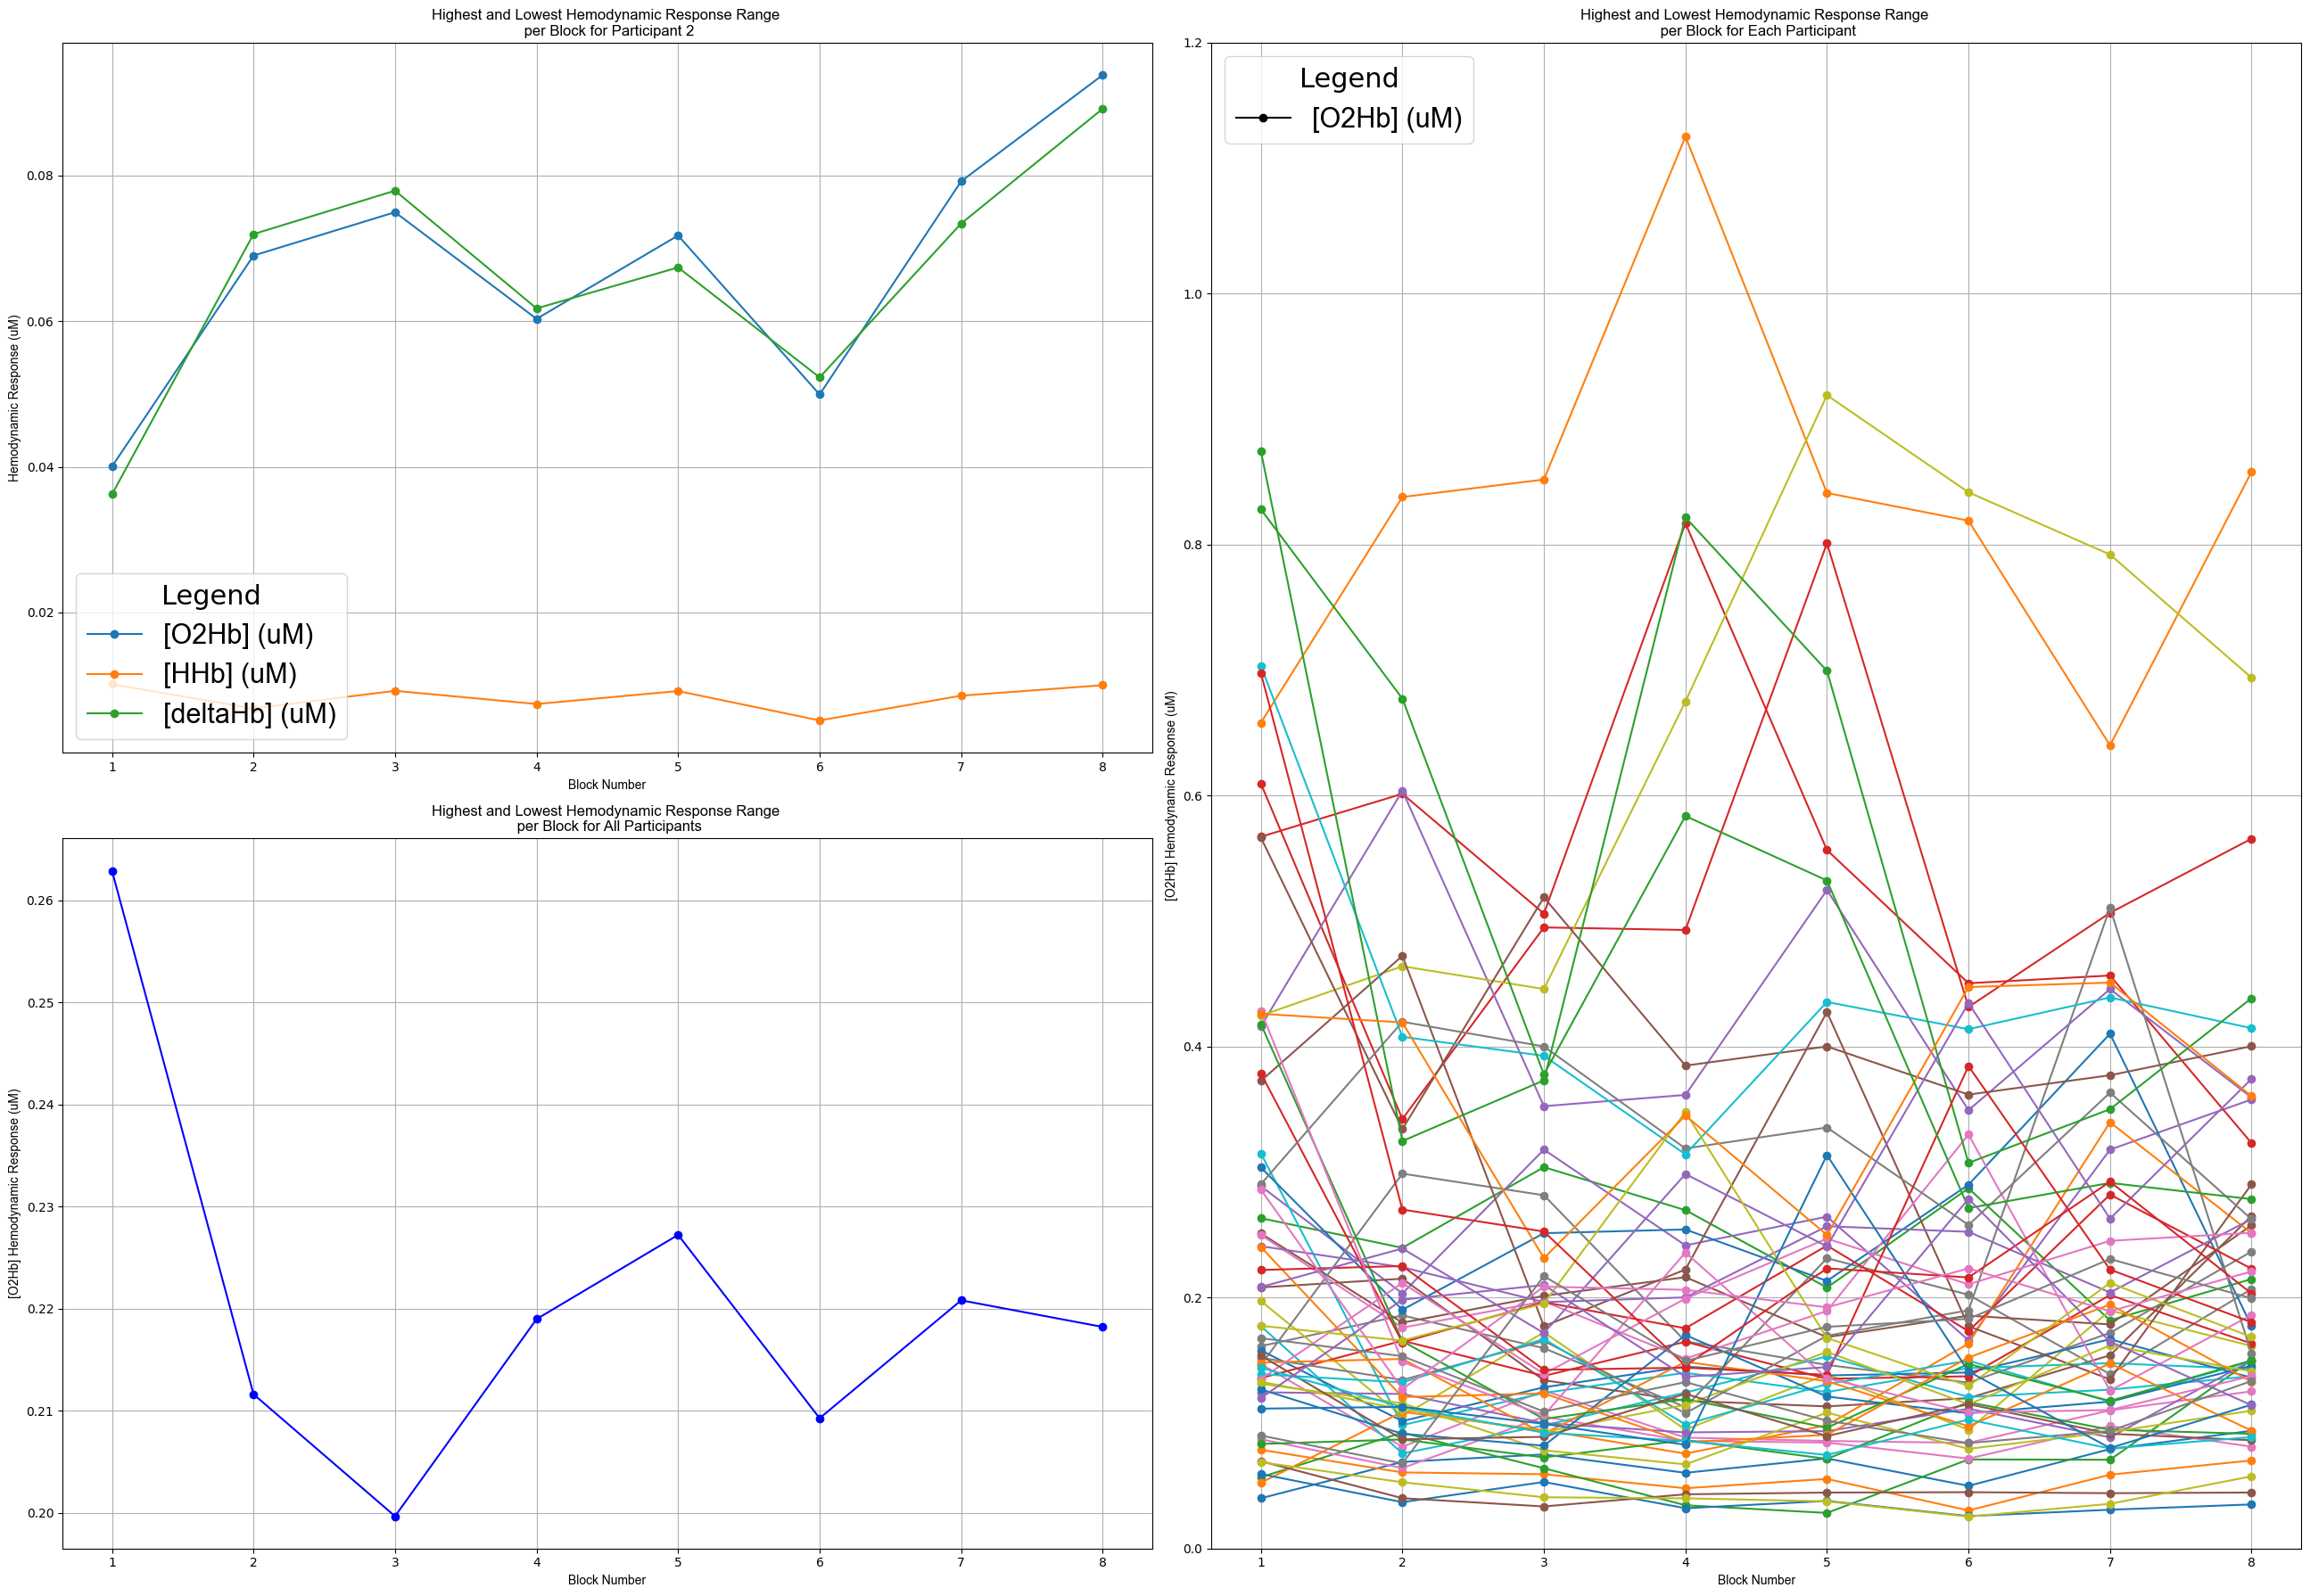

In [50]:
# Initialize the difference peaks dictionary
for participant_index in fnirs_dictionary:
    if 'fnirs_subexperiment_highest_peaks' not in fnirs_dictionary[participant_index] or 'fnirs_subexperiment_lowest_peaks' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'] = {}
    
    for subexperiment_number in fnirs_dictionary[participant_index]['fnirs_subexperiment_highest_peaks']:
        if subexperiment_number not in fnirs_dictionary[participant_index]['fnirs_subexperiment_lowest_peaks']:
            continue
        
        highest_peaks = fnirs_dictionary[participant_index]['fnirs_subexperiment_highest_peaks'][subexperiment_number]
        lowest_peaks = fnirs_dictionary[participant_index]['fnirs_subexperiment_lowest_peaks'][subexperiment_number]
        
        difference_peaks = {
            'O2Hb': abs(highest_peaks['O2Hb']['highest_peak'] - lowest_peaks['O2Hb']['lowest_peak']),
            'HHb': abs(highest_peaks['HHb']['highest_peak'] - lowest_peaks['HHb']['lowest_peak']),
            'deltaHb': abs(highest_peaks['deltaHb']['highest_peak'] - lowest_peaks['deltaHb']['lowest_peak'])
        }
        
        fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexperiment_number] = difference_peaks

print(fnirs_dictionary[2]['fnirs_subexperiment_difference_peaks'][1])

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Extract the data for plotting for a specific participant
participant_index = 2  
subexperiment_numbers = sorted(fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'].keys())
o2hb_peaks = [fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexp]['O2Hb'] for subexp in subexperiment_numbers]
hhb_peaks = [fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexp]['HHb'] for subexp in subexperiment_numbers]
deltahb_peaks = [fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexp]['deltaHb'] for subexp in subexperiment_numbers]

# Extract the data for plotting for all participants
all_participants_o2hb_peaks = {subexp: [] for subexp in subexperiment_numbers}
for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary and 'fnirs_subexperiment_difference_peaks' in fnirs_dictionary[participant_index]:
        for subexp in subexperiment_numbers:
            if subexp in fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks']:
                all_participants_o2hb_peaks[subexp].append(fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexp]['O2Hb'])

# Calculate the average O2Hb peak values for all participants per block
avg_o2hb_peaks_all_participants = [sum(all_participants_o2hb_peaks[subexp]) / len(all_participants_o2hb_peaks[subexp]) for subexp in subexperiment_numbers]

# Create subplots with GridSpec
fig = plt.figure(figsize=(26, 18))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Plot the data for the specific participant
ax0 = plt.subplot(gs[0, 0])
ax0.plot(subexperiment_numbers, o2hb_peaks, label='[O2Hb] (uM)', marker='o')
ax0.plot(subexperiment_numbers, hhb_peaks, label='[HHb] (uM)', marker='o')
ax0.plot(subexperiment_numbers, deltahb_peaks, label='[deltaHb] (uM)', marker='o')
ax0.set_xlabel('Block Number', fontname='Arial')
ax0.set_ylabel('Hemodynamic Response (uM)', fontname='Arial')
ax0.set_title('Highest and Lowest Hemodynamic Response Range \n per Block for Participant 2', fontname='Arial')
ax0.legend(loc='lower left', prop={'family': 'Arial', 'size': 22}, title='Legend', title_fontsize=22)
ax0.grid(True)

# Plot the data for all participants
ax1 = plt.subplot(gs[1, 0])
ax1.plot(subexperiment_numbers, avg_o2hb_peaks_all_participants, label='[O2Hb] (uM)', marker='o', color='blue')
ax1.set_xlabel('Block Number', fontname='Arial')
ax1.set_ylabel('[O2Hb] Hemodynamic Response (uM)', fontname='Arial')
ax1.set_title('Highest and Lowest Hemodynamic Response Range \n per Block for All Participants', fontname='Arial')
#ax1.legend(loc='lower left', prop={'family': 'Arial', 'size': 22}, title='Legend', title_fontsize=22)
ax1.grid(True)

# Plot the data for each participant
ax2 = plt.subplot(gs[:, 1])
for participant_index in participants_indexes:
    if participant_index in fnirs_dictionary and 'fnirs_subexperiment_difference_peaks' in fnirs_dictionary[participant_index]:
        o2hb_peaks_participant = [fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks'][subexp]['O2Hb'] for subexp in subexperiment_numbers if subexp in fnirs_dictionary[participant_index]['fnirs_subexperiment_difference_peaks']]
        ax2.plot(subexperiment_numbers, o2hb_peaks_participant, marker='o')

ax2.set_xlabel('Block Number', fontname='Arial')
ax2.set_ylabel('[O2Hb] Hemodynamic Response (uM)', fontname='Arial')
ax2.set_title('Highest and Lowest Hemodynamic Response Range \n per Block for Each Participant', fontname='Arial')
ax2.plot([], [], label='[O2Hb] (uM)', color='black', marker='o')
ax2.legend(loc='upper left', prop={'family': 'Arial', 'size': 22}, title='Legend', title_fontsize=22)
ax2.set_ylim(0, 1.2)
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

{'O2Hb': -0.0023290808098383464, 'HHb': -0.003945149983818493, 'deltaHb': 0.0016160691739801197}


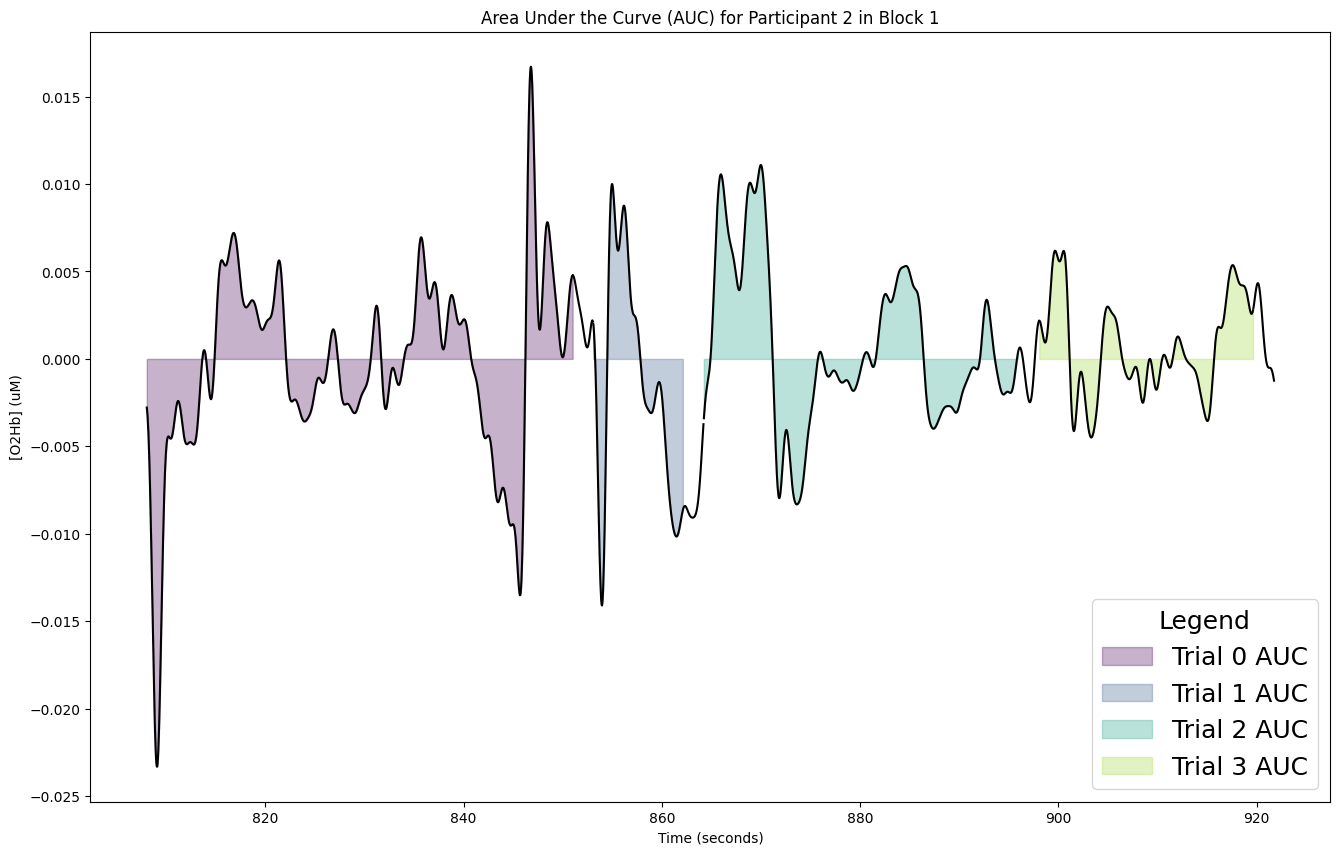

In [52]:
# fnirs_subexperiment_auc initialization

import numpy as np
import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Function to calculate AUC
def calculate_auc(time, values):
    if len(time) < 2 or len(values) < 2:
        return None
    return auc(time, values)

for participant_index in participants_indexes:
    if participant_index not in fnirs_dictionary:
        continue

    if 'fnirs_subexperiment_data' not in fnirs_dictionary[participant_index]:
        continue
    
    fnirs_dictionary[participant_index]['fnirs_subexperiment_auc'] = {}
    
    for subexperiment_number, subexperiment_data in fnirs_dictionary[participant_index]['fnirs_subexperiment_data'].items():
        o2hb_column = '[O2Hb]'
        hhb_columns = [col for col in subexperiment_data.columns if '[HHb]' in col]
        deltahb_columns = [col for col in subexperiment_data.columns if '[deltaHb]' in col]
        
        # Concatenate data for all trials within the subexperiment
        concatenated_data = subexperiment_data[subexperiment_data['stimulus1'].apply(lambda x: 'isCorrect?' not in x)]
        
        # Calculate AUC for each type
        auc_o2hb = calculate_auc(concatenated_data['times_secs'], concatenated_data[o2hb_column]) if o2hb_column in concatenated_data.columns else None
        auc_hhb = calculate_auc(concatenated_data['times_secs'], concatenated_data[hhb_columns[0]]) if hhb_columns else None
        auc_deltahb = calculate_auc(concatenated_data['times_secs'], concatenated_data[deltahb_columns[0]]) if deltahb_columns else None
        
        # Update the dictionary with AUC values
        fnirs_dictionary[participant_index]['fnirs_subexperiment_auc'][subexperiment_number] = {
            'O2Hb': auc_o2hb,
            'HHb': auc_hhb,
            'deltaHb': auc_deltahb
        }
        
print(fnirs_dictionary[2]['fnirs_subexperiment_auc'][1])

# Define participant ID and subexperiment number
participant_id = 2
subexperiment_number = 1

# Visualization of AUC for the specified participant and subexperiment
subexperiment_data = fnirs_dictionary[participant_id]['fnirs_subexperiment_data'][subexperiment_number]

if participant_id in fnirs_dictionary and subexperiment_number in fnirs_dictionary[participant_id]['fnirs_subexperiment_data']:
    o2hb_column = '[O2Hb]'
    
    trial_numbers = subexperiment_data['stimulus1'].unique()
    
    plt.figure(figsize=(16, 10))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(trial_numbers)))
    
    for i, trial_number in enumerate(trial_numbers):
        trial_data = subexperiment_data[subexperiment_data['stimulus1'] == trial_number]
        
        if o2hb_column in trial_data.columns:
            plt.plot(trial_data['times_secs'], trial_data[o2hb_column], color='black', label='_nolegend_')
            if 'isCorrect?' not in trial_number:
                trial_num = trial_number.split('RunningTrial ')[1].split('_')[0]
                plt.fill_between(trial_data['times_secs'], trial_data[o2hb_column], color=colors[i], alpha=0.3, label=f'Trial {trial_num} AUC')
    
    plt.title(f'Area Under the Curve (AUC) for Participant {participant_id} in Block {subexperiment_number}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('[O2Hb] (uM)')
    legend = plt.legend(loc='lower right', prop={'size': 18}, frameon=True, title='Legend', title_fontsize=18)
    plt.show()

### Output to CSV

In [57]:
data = []

# Iterate over the participant IDs
for participant_id in participants_indexes:
    fnirs_data = fnirs_dictionary.get(participant_id, None)

    # Iterate over the sub-experiments
    for subexperiment in range(1, 9):
        # Create a dictionary for each participant and sub-experiment
        participant_data = {
            'participant_number': participant_id,
            'subexperiment_number': subexperiment,
            'O2Hb_highest_peak': fnirs_data['fnirs_subexperiment_highest_peaks'].get(subexperiment, {}).get('O2Hb', {}).get('highest_peak', 0) if fnirs_data else 0,
            'O2Hb_lowest_peak': fnirs_data['fnirs_subexperiment_lowest_peaks'].get(subexperiment, {}).get('O2Hb', {}).get('lowest_peak', 0) if fnirs_data else 0,
            'O2Hb_average_peak': fnirs_data['fnirs_subexperiment_avg_peaks'].get(subexperiment, {}).get('O2Hb', 0) if fnirs_data else 0,
            'O2Hb_difference_peak': fnirs_data['fnirs_subexperiment_difference_peaks'].get(subexperiment, {}).get('O2Hb', 0) if fnirs_data else 0,
            'O2Hb_auc': fnirs_data['fnirs_subexperiment_auc'].get(subexperiment, {}).get('O2Hb', 0) if fnirs_data else 0
        }

        # Add the highest, lowest, average, difference, and auc peaks for the 4 trials in the sub-experiment
        peak_types = ['highest', 'lowest', 'average', 'difference', 'auc']
        for peak_type in peak_types:
            trial_indices = range((subexperiment-1)*4, subexperiment*4)
            for i, trial_index in enumerate(trial_indices):
                if fnirs_data is not None:
                    if peak_type == 'auc':
                        key = 'fnirs_trial_auc'
                    else:
                        key = f'fnirs_trial_{peak_type}_peaks'
                        peak_key = f'{peak_type}_peak'
                    
                    if key in fnirs_data and trial_index in fnirs_data[key]:
                        trial_peaks = fnirs_data[key][trial_index]
                        if peak_type == 'auc':
                            participant_data[f'O2Hb_{peak_type}_peak_trial_{i+1}'] = trial_peaks['O2Hb']
                        else:
                            if isinstance(trial_peaks['O2Hb'], dict):
                                participant_data[f'O2Hb_{peak_type}_peak_trial_{i+1}'] = trial_peaks['O2Hb'][peak_key]
                            else:
                                participant_data[f'O2Hb_{peak_type}_peak_trial_{i+1}'] = trial_peaks['O2Hb']
                    else:
                        participant_data[f'O2Hb_{peak_type}_peak_trial_{i+1}'] = 0

        # Convert the dictionary to a Series and append it to the list
        data.append(pd.Series(participant_data, name=f'{participant_id}_subexperiment{subexperiment}'))
        
# Concatenate the Series in the list into a DataFrame
fnirs_analysis_df = pd.concat(data, axis=1).T

In [58]:
fnirs_analysis_df.to_csv('fnirs_analysis.csv', index=False)